# Optimizing a Project's Payoff

In [16]:
suppressMessages(library(tidyverse))
suppressMessages(library(lubridate))

my_db <- src_postgres("donorschoose")
projects_tbl <- tbl(my_db, "projects")

In [17]:
price_funded <- projects_tbl  %>% 
  filter(date_posted > "2010-01-01", date_posted < "2012-01-01") %>% 
  filter(total_price_excluding_optional_support < 10000)  %>% 
  mutate(funded = funding_status == "completed")  %>% 
  mutate(price = total_price_excluding_optional_support)  %>%
  select(funded, price)  %>% 
  collect()

Warning message:
“Only first 100,000 results retrieved. Use n = Inf to retrieve all.”

In [18]:
pryr::object_size(price_funded)

1.2 MB

In [19]:
price_funded  %>% 
  summarise(max = max(price))

max
9900.11


In [20]:
mod <- glm(funded ~ price, data = price_funded, family = "binomial")
#summary(mod)
new_data <- tibble(price = seq(0, 8000, by = 1))
probs <- predict(mod, newdata = new_data, type = "response")
new_data <- new_data  %>% 
  mutate(
    probs = probs,
    payoff = probs * price
  )
head(new_data)

price,probs,payoff
0,0.8149237,0.0000000
1,0.8147469,0.8147469
2,0.8145700,1.6291401
3,0.8143930,2.4431791
4,0.8142159,3.2568636
5,0.8140386,4.0701931


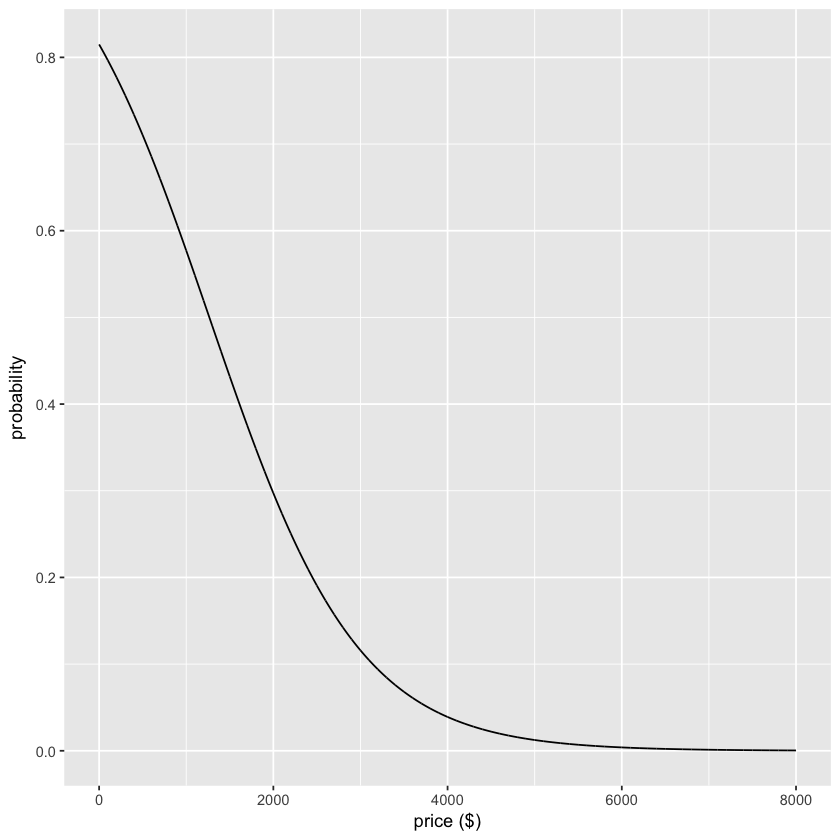

In [21]:
new_data  %>% 
  ggplot(aes(price, probs)) +
  geom_line() +
  labs(x = "price ($)", y = "probability")
ggsave(file = "funding_probability.png", path = "figures/", width = 4, height = 4)

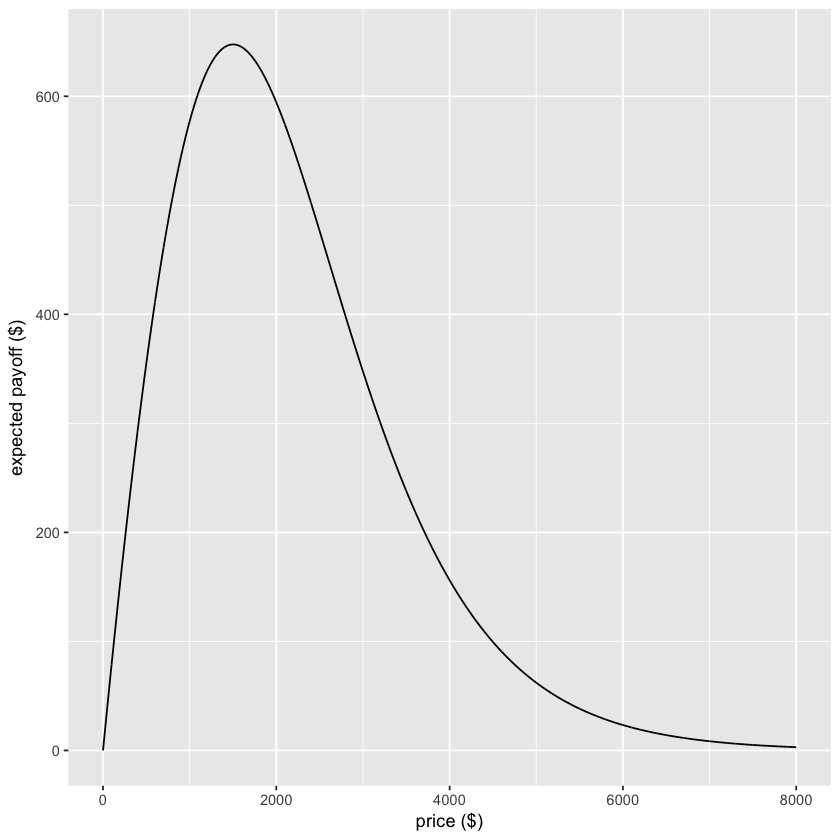

In [22]:
new_data  %>% 
  ggplot(aes(price, payoff)) +
  geom_line()+
  labs(x = "price ($)", y = "expected payoff ($)")
ggsave(file = "funding_expectation.png", path = "figures/", width = 4, height = 4)

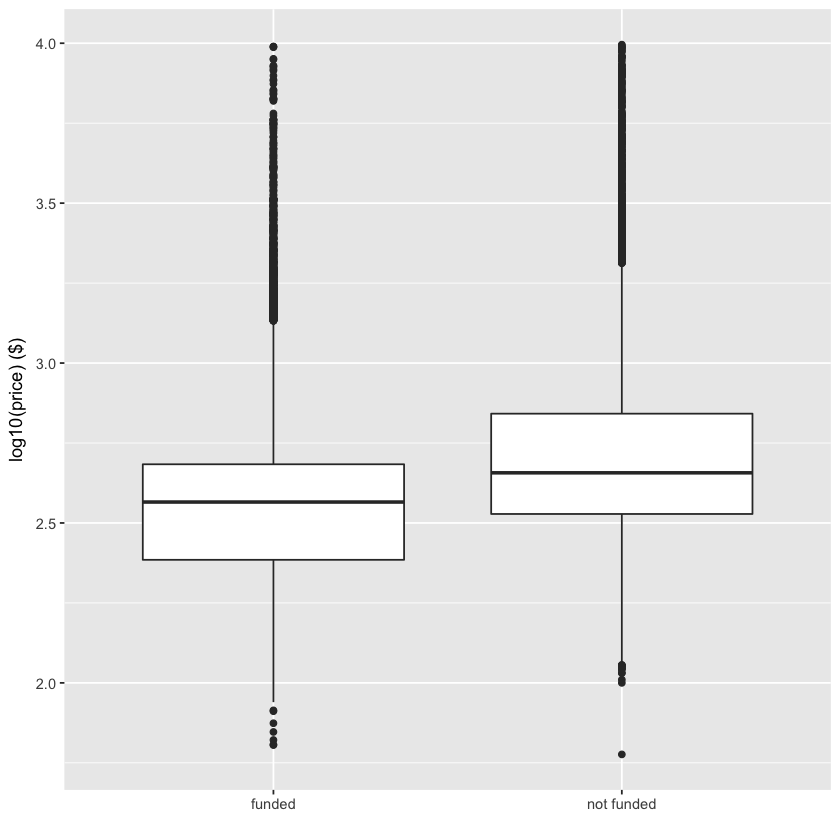

In [47]:
price_funded  %>% 
  mutate(funded = ifelse(funded, "funded", "not funded"))  %>% 
  ggplot(aes(funded, log10(price))) +
  geom_boxplot() +
  labs(x = "", y = "log10(price) ($)")
ggsave(file = "boxplot_price_funding.png", path = "figures/", width = 4, height = 4)

               Df Sum Sq Mean Sq F value Pr(>F)    
funded          1   1709  1709.4    5623 <2e-16 ***
Residuals   99998  30400     0.3                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

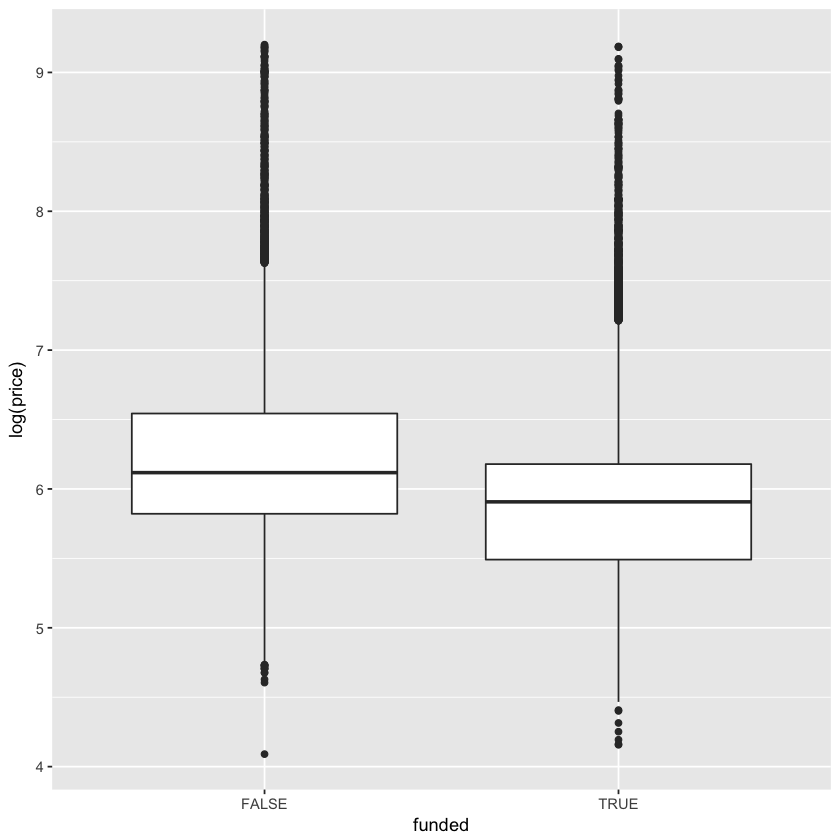

In [44]:
summary(aov(log(price) ~ funded, data = price_funded))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


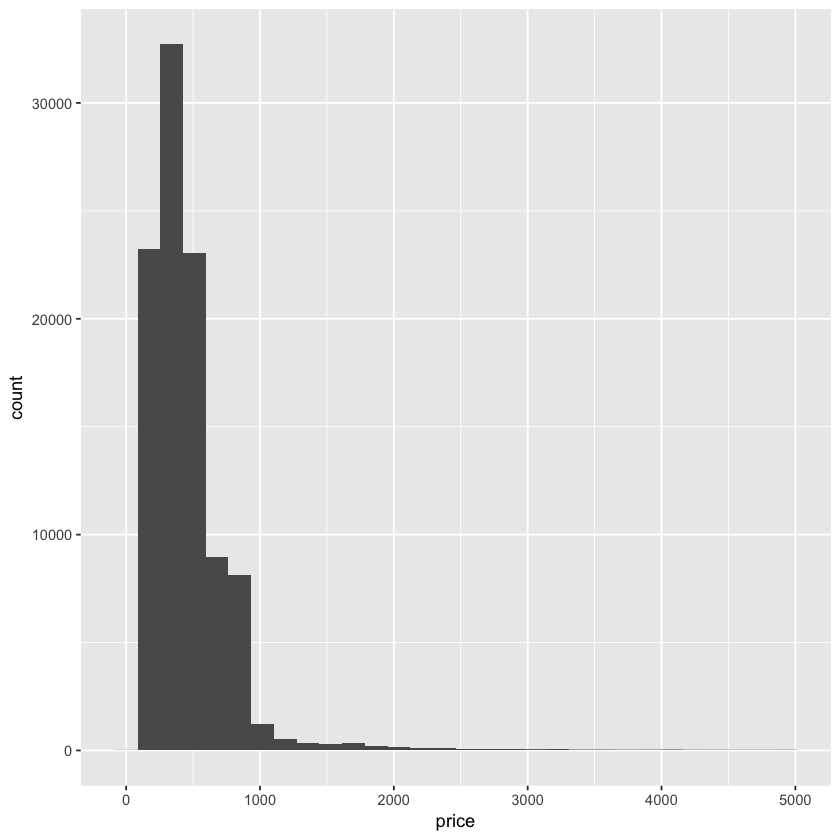

In [24]:
price_funded  %>% 
  filter(price < 5000)  %>% 
  ggplot(aes(price)) +
  geom_histogram()

In [31]:
# optimal price
opt_price <- new_data$price[which.max(new_data$payoff)]
opt_price

[1] 1501

In [38]:
# what if half of teachers asking for more than optimal scaled back to optimal?
adj_price_funded <- price_funded  %>% 
  mutate(price_adj = ifelse(price > opt_price, opt_price, price)) 
